In [1]:
%pip install dabl
# %pip install dtale
# %pip install imblearn
%pip install keras-tuner
# %pip install numpy
# %pip install pandas
# %pip install sklearn
# %pip install tensorflow

     |████████████████████████████████| 558 kB 893 kB/s            
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import datetime
import shutil
import warnings
from pickle import dump

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from dabl import SimpleClassifier, SimpleRegressor, plot
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import display
from keras_tuner.tuners import BayesianOptimization, Hyperband, RandomSearch
from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.datasets import (load_breast_cancer, load_diabetes, load_iris,
                              load_wine)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectPercentile, chi2, f_classif
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.model_selection import (RandomizedSearchCV, StratifiedKFold,
                                     train_test_split)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib

%matplotlib inline
time_stamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
set_config(display="diagram", print_changed_only=False)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
plt.rcParams["figure.figsize"] = [12.8, 7.2]
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings("ignore")
print(device_lib.list_local_devices())
print(tf.config.list_physical_devices("GPU"))
print(tf.test.gpu_device_name())
!cat /proc/cpuinfo | grep "model name"
!cat /proc/meminfo | grep "MemTotal"
!nvidia-smi

/opt/conda/lib/python3.7/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15162665432724176195
]
[]

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
MemTotal:       18433324 kB
/bin/bash: nvidia-smi: command not found


In [7]:
RANDOM_STATE = 11
SEARCH = ["hyperband", "random", "bayesian"][0]
EPOCHS = 500
MAX_TRIALS = 20
DUPLICATES = 0
CLASSIFICATION = 2

In [8]:
df, y_label = load_iris(as_frame=True)["frame"], "target"

print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"Duplicates Percentage: {df.duplicated().sum() / df.shape[0] * 100:.2f}%")
if DUPLICATES:
    print(f"Duplicates have been kept {df.shape}.")
else:
    df.drop_duplicates(inplace=True)
    print(f"Duplicates have been removed {df.shape}.")
display(df.sample(3))

Current Shape: (150, 5).
-------------------------------------------------------
Duplicates Percentage: 0.67%
Duplicates have been removed (149, 5).


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
75,6.6,3.0,4.4,1.4,1
41,4.5,2.3,1.3,0.3,0
35,5.0,3.2,1.2,0.2,0


In [10]:
df.dropna(subset=[y_label], inplace=True)
print("Data cleaning has been completed.")

Data cleaning has been completed.


In [11]:
print(f"Current Shape: {df.shape}.")
df_info = pd.DataFrame(
    {
        "column": [col for col in df.columns],
        "dtype": [f"{df[col].dtype}" for col in df.columns],
        "na": [f"{df[col].isna().sum()}" for col in df.columns],
        "na %": [f"{round(df[col].isna().sum() / df[col].shape[0] * 100)}%" for col in df.columns],
        "outliers": [f"{((df[col] < (df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))) | (df[col] > (df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))))).sum()}" if np.issubsctype(df[col].dtype, np.number) else "n/a" for col in df.columns],
        "outliers %": [f"{round((((df[col] < (df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))) | (df[col] > (df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))))).sum()) / df[col].shape[0] * 100)}%" if np.issubsctype(df[col].dtype, np.number) else "n/a" for col in df.columns],
        "skewness": [f"{df[col].skew(axis=0, skipna=True):.2f}" if np.issubsctype(df[col].dtype, np.number) else "n/a" for col in df.columns],
        "corr": [f"{round(df[col].corr(other=df[y_label]) * 100)}%" if np.issubsctype(df[col].dtype, np.number) else "n/a" for col in df.columns],
        "nunique": [f"{df[col].nunique()}" for col in df.columns],
        "unique": [df[col].unique() for col in df.columns],
    }
).sort_values(by="dtype", ascending=False)
display(df_info)

Current Shape: (149, 5).


,column,dtype,na,na %,outliers,outliers %,skewness,corr,nunique,unique
4,target,int64,0,0%,0,0%,0.01,100%,3,"[0, 1, 2]"
0,sepal length (cm),float64,0,0%,0,0%,0.31,79%,35,"[5.1, 4.9, 4.7, 4.6, 5.0, 5.4, 4.4, 4.8, 4.3, ..."
1,sepal width (cm),float64,0,0%,4,3%,0.31,-42%,23,"[3.5, 3.0, 3.2, 3.1, 3.6, 3.9, 3.4, 2.9, 3.7, ..."
2,petal length (cm),float64,0,0%,0,0%,-0.26,95%,43,"[1.4, 1.3, 1.5, 1.7, 1.6, 1.1, 1.2, 1.0, 1.9, ..."
3,petal width (cm),float64,0,0%,0,0%,-0.09,96%,22,"[0.2, 0.4, 0.3, 0.1, 0.5, 0.6, 1.4, 1.5, 1.3, ..."


In [12]:
OUTLIERS = ["keep", "cap", "log_transform", "drop"][3]
col_outlier = [col for col in df.columns if np.issubsctype(df[col].dtype, np.number) and col in ["sepal width (cm)"]]
q1, q3 = df[col_outlier].quantile(0.25), df[col_outlier].quantile(0.75)
iqr = q3 - q1
lower_range, upper_range = q1 - (1.5 * iqr), q3 + (1.5 * iqr)
condition = ~((df[col_outlier] < lower_range) | (df[col_outlier] > upper_range)).any(axis=1)
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"Scanning for outliers in {col_outlier}.")
print(f"Outliers Percentage: {(df.shape[0] - df[condition].shape[0]) / df.shape[0] * 100:.2f}%")
if OUTLIERS == "keep":
    print(f"Outliers have been kept {df.shape}.")
elif OUTLIERS == "cap":
    for col in col_outlier:
        df[col] = np.where(df[col] < lower_range[col], lower_range[col], df[col])
        df[col] = np.where(df[col] > upper_range[col], upper_range[col], df[col])
    print(f"Outliers have been capped {df.shape}.")
elif OUTLIERS == "log_transform":
    for col in col_outlier:
        df[col] = np.log(df[col])
    print(f"Outliers have been log transformed {df.shape}.")
else:
    df = df[condition]
    print(f"Outliers have been removed {df.shape}.")

Current Shape: (149, 5).
-------------------------------------------------------
Scanning for outliers in ['sepal width (cm)'].
Outliers Percentage: 2.68%
Outliers have been removed (145, 5).


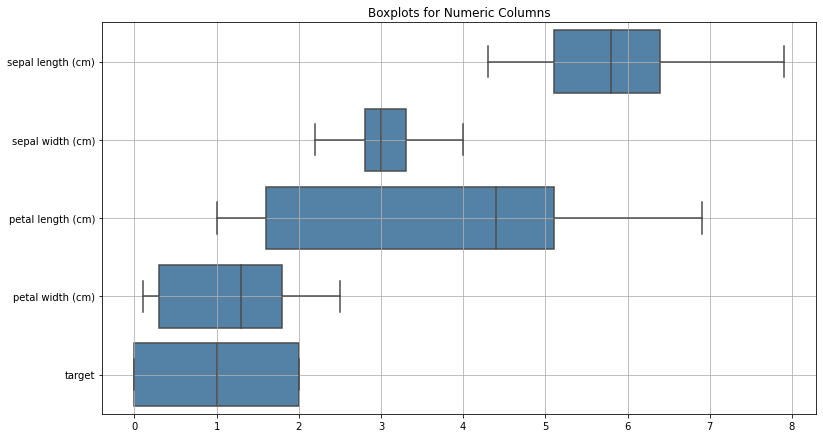

In [13]:
plt.title("Boxplots for Numeric Columns")
sns.boxplot(
    data=df[[col for col in df.columns if np.issubsctype(df[col].dtype, np.number)]],
    orient="h",
    color="steelblue"
)
plt.grid()
plt.show()

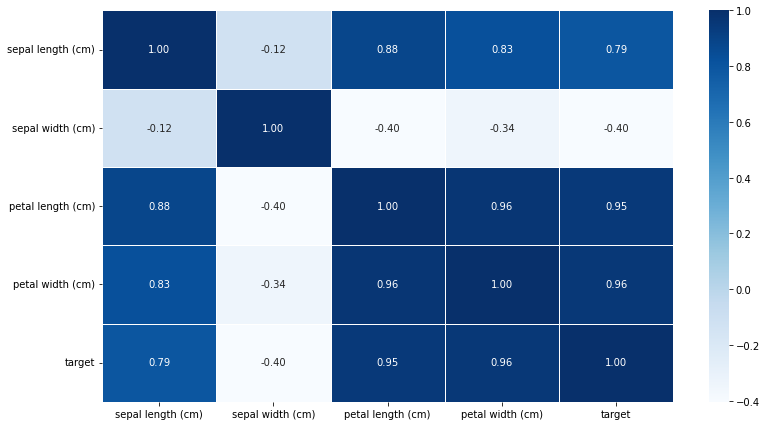

In [14]:
sns.heatmap(df.corr(), cmap="Blues", fmt=".2f", annot=True, linewidths=1)
plt.show()

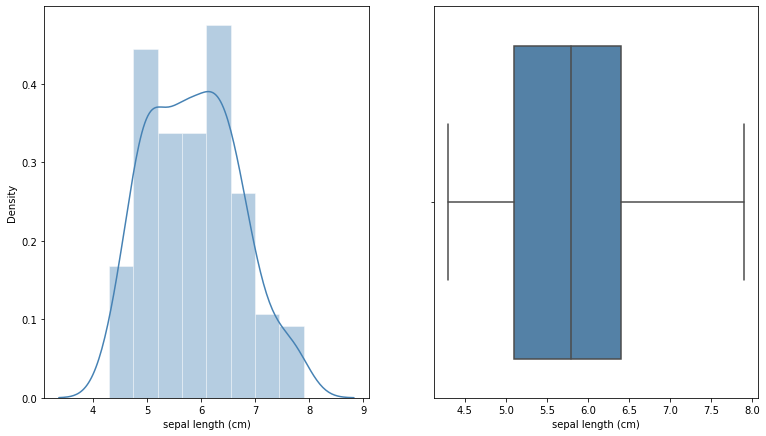

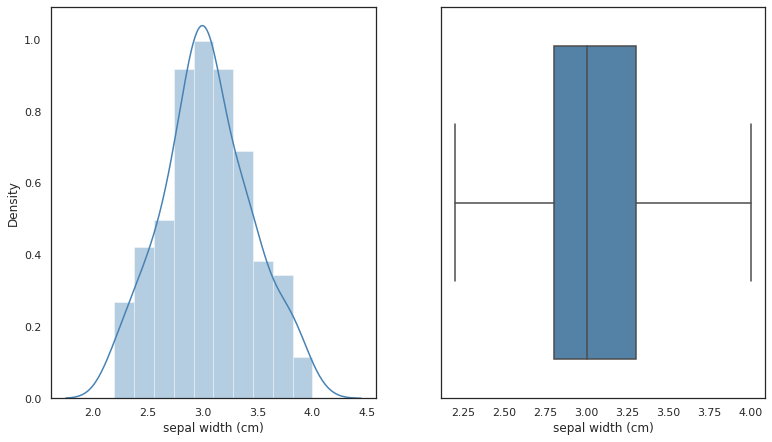

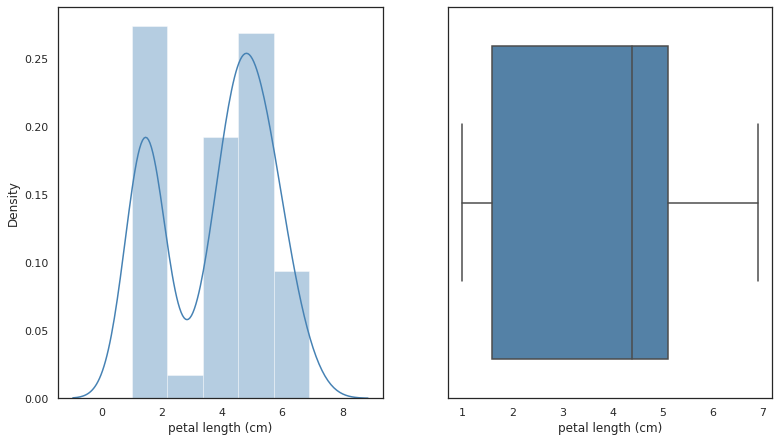

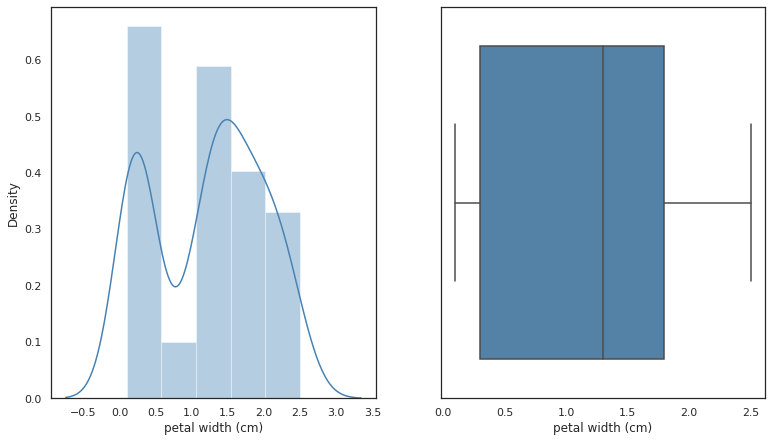

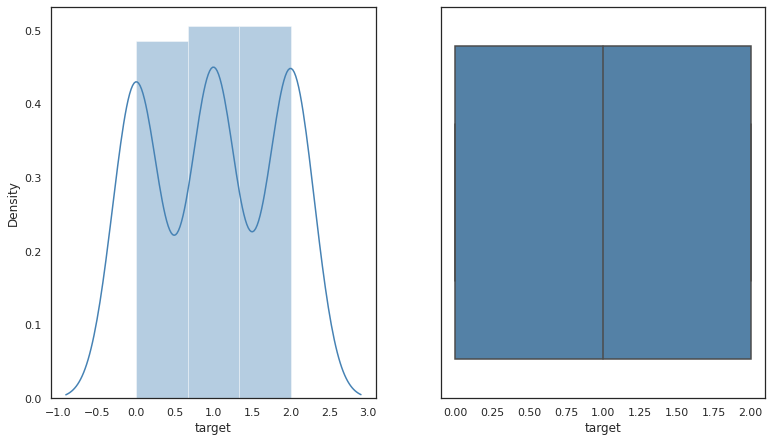

In [15]:
for col in df.columns:
    if np.issubsctype(df[col].dtype, np.number):
        fig, ax = plt.subplots(nrows=1, ncols=2)
        sns.set(style="white", palette="muted", color_codes=True)
        sns.distplot(x=df[col], ax=ax[0], color="steelblue", kde=True).set_xlabel(f"{col}")
        sns.boxplot(x=df[col], ax=ax[1], color="steelblue").set_xlabel(f"{col}")
plt.show()

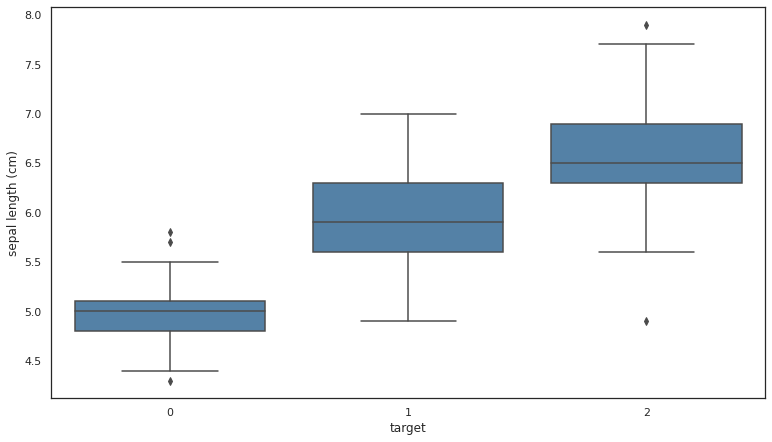

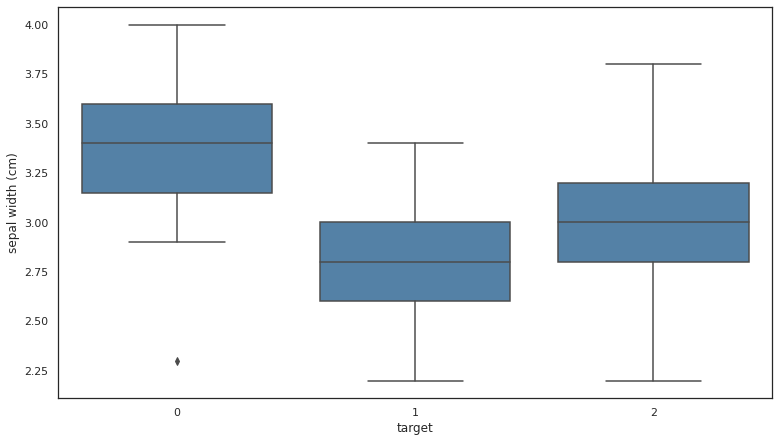

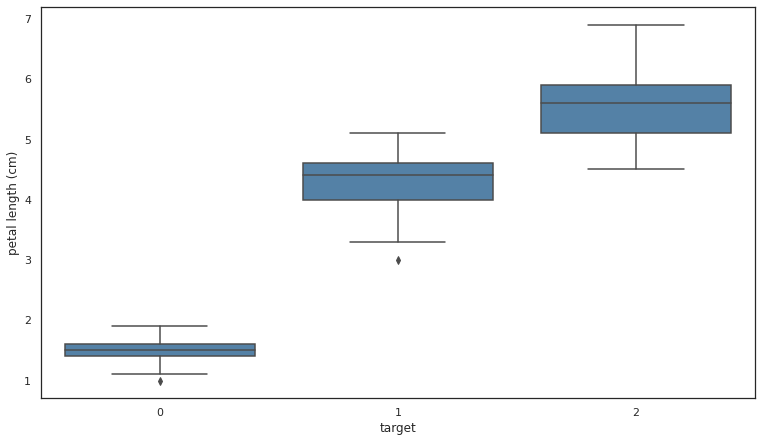

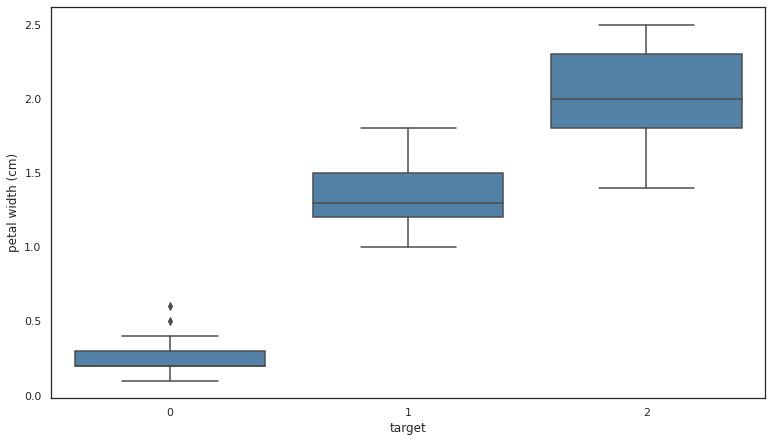

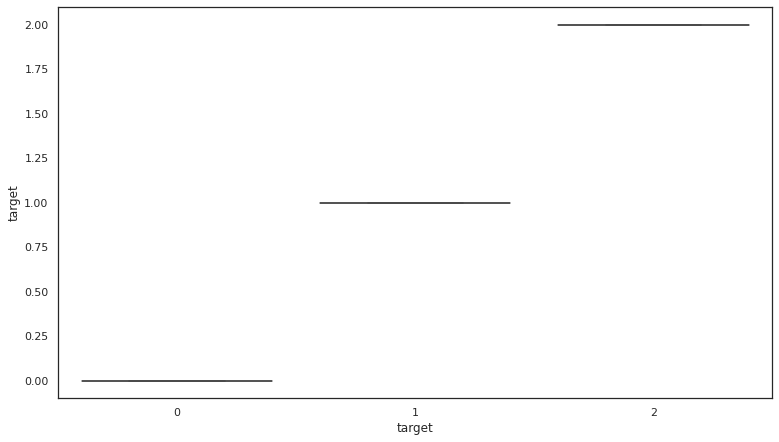

In [16]:
if CLASSIFICATION:
    for col in df.columns:
        if np.issubsctype(df[col].dtype, np.number):
            fig, ax = plt.subplots(nrows=1, ncols=1)
            sns.set(style="white", palette="muted", color_codes=True)
            sns.boxplot(x=y_label, y=col, data=df, color="steelblue")
    plt.show()

In [17]:
display(df.describe().round(2).T.style.background_gradient(cmap="Blues"))
display(df.quantile([0.01, 0.99]).T.style.background_gradient(cmap="Blues"))

,count,mean,std,min,25%,50%,75%,max
sepal length (cm),145.000000,5.860000,0.840000,4.300000,5.100000,5.800000,6.400000,7.900000
sepal width (cm),145.000000,3.040000,0.400000,2.200000,2.800000,3.000000,3.300000,4.000000
petal length (cm),145.000000,3.800000,1.760000,1.000000,1.600000,4.400000,5.100000,6.900000
petal width (cm),145.000000,1.220000,0.760000,0.100000,0.300000,1.300000,1.800000,2.500000
target,145.000000,1.010000,0.820000,0.000000,0.000000,1.000000,2.000000,2.000000


,0.01,0.99
sepal length (cm),4.400000,7.700000
sepal width (cm),2.200000,3.900000
petal length (cm),1.144000,6.700000
petal width (cm),0.100000,2.500000
target,0.000000,2.000000


-------------------------------------------------------
total na %: 0.00%
-------------------------------------------------------
col_oe: []
col_ohe: []
col_num: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
total cols for preprocessor: 4


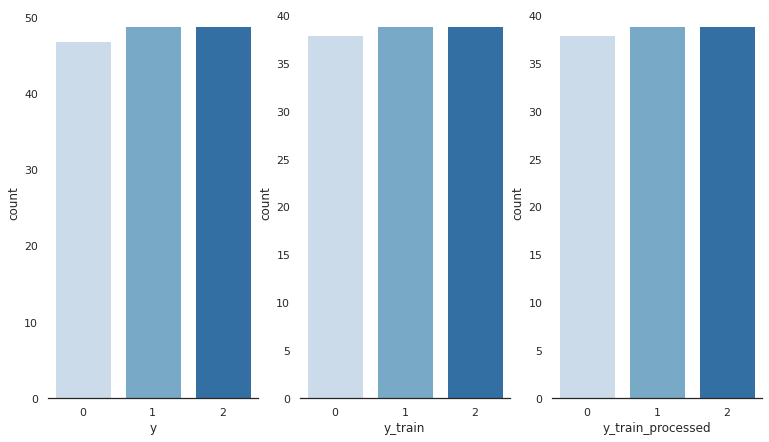

-------------------------------------------------------
y:
1    0.337931
2    0.337931
0    0.324138
Name: target, dtype: float64
-------------------------------------------------------
y_train:
1    0.336207
2    0.336207
0    0.327586
Name: target, dtype: float64
-------------------------------------------------------
y_train_processed:
1    0.336207
2    0.336207
0    0.327586
Name: target, dtype: float64
-------------------------------------------------------
y_test:
1    0.344828
2    0.344828
0    0.310345
Name: target, dtype: float64
-------------------------------------------------------
y_test_processed:
1    0.344828
2    0.344828
0    0.310345
Name: target, dtype: float64
-------------------------------------------------------
X: (145, 4)	X_train: (116, 4)	X_train_processed:(116, 4)	X_test: (29, 4)		X_test_processed:(29, 4)
y: (145,)	y_train: (116,)		y_train_processed:(116,)	y_test: (29,)		y_test_processed:(29,)
-------------------------------------------------------


In [18]:
OVERSAMPLE = ["none", "undersample", "oversample", "combine"][0]
X, y = df.drop(y_label, axis=1), df[y_label]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=[None, y, y][CLASSIFICATION],
    random_state=RANDOM_STATE,
)
col_oe = []
preprocessor_oe = make_pipeline(
    (SimpleImputer(strategy="most_frequent")),
    (OrdinalEncoder(categories=[["no", "yes"]])),
    (MinMaxScaler()),
)
col_ohe = [
    col
    for col in X_train.columns
    if np.issubsctype(X_train[col].dtype, np.object0)
    and col not in col_oe
    and X_train[col].nunique() <= 10
]
preprocessor_ohe = make_pipeline(
    (SimpleImputer(strategy="most_frequent")),
    (OneHotEncoder(drop="first", handle_unknown="ignore")),
)
col_num = [
    col for col in X_train.columns if np.issubsctype(X_train[col].dtype, np.number)
]
preprocessor_num = make_pipeline(
    (KNNImputer()),
    (MinMaxScaler()),
)
preprocessor = make_column_transformer(
    (preprocessor_oe, col_oe),
    (preprocessor_ohe, col_ohe),
    (preprocessor_num, col_num),
    sparse_threshold=0
)
X_train_processed, y_train_processed = preprocessor.fit_transform(X_train), y_train
X_test_processed, y_test_processed = preprocessor.transform(X_test), y_test
print("-------------------------------------------------------")
print(f"total na %: {df.isnull().sum().sum() / np.product(df.shape) * 100:.2f}%")
print("-------------------------------------------------------")
print(f"col_oe: {col_oe}")
print(f"col_ohe: {col_ohe}")
print(f"col_num: {col_num}")
print(f"total cols for preprocessor: {len(col_oe) + len(col_ohe) + len(col_num)}")
if CLASSIFICATION:
    if OVERSAMPLE == "undersample":
        X_train_processed, y_train_processed = RandomUnderSampler(random_state=RANDOM_STATE, sampling_strategy="not minority").fit_resample(X_train_processed, y_train_processed)
    elif OVERSAMPLE == "oversample":
        X_train_processed, y_train_processed = SMOTE(random_state=RANDOM_STATE, sampling_strategy="not majority").fit_resample(X_train_processed, y_train_processed)
    elif OVERSAMPLE == "combine":
        X_train_processed, y_train_processed = SMOTEENN(random_state=RANDOM_STATE, sampling_strategy="not majority").fit_resample(X_train_processed, y_train_processed)
    fig, ax = plt.subplots(nrows=1, ncols=3)
    sns.set(style="white", palette="muted", color_codes=True)
    sns.despine(left=True)
    sns.countplot(y, ax=ax[0], palette="Blues").set_xlabel("y")
    sns.countplot(y_train, ax=ax[1], palette="Blues").set_xlabel("y_train")
    sns.countplot(y_train_processed, ax=ax[2], palette="Blues").set_xlabel("y_train_processed")
    plt.show()
    print("-------------------------------------------------------")
    print(f"y:\n{y.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_train:\n{y_train.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_train_processed:\n{y_train_processed.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_test:\n{y_test.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_test_processed:\n{y_test_processed.value_counts(normalize=True)}")
print("-------------------------------------------------------")
print(f"X: {X.shape}\tX_train: {X_train.shape}\tX_train_processed:{X_train_processed.shape}\tX_test: {X_test.shape}\t\tX_test_processed:{X_test_processed.shape}")
print(f"y: {y.shape}\ty_train: {y_train.shape}\t\ty_train_processed:{y_train_processed.shape}\ty_test: {y_test.shape}\t\ty_test_processed:{y_test_processed.shape}")
print("-------------------------------------------------------")

In [19]:
for col in col_oe + col_ohe:
    fig, ax = plt.subplots(nrows=1, ncols=2)
    sns.set(style="white", palette="muted", color_codes=True)
    sns.despine(left=True)
    sns.countplot(x=df[col], ax=ax[0], color="steelblue", hue=df[y_label] if CLASSIFICATION else None).set_xlabel(f"{col}")
    ax[1].pie(x=df[col].value_counts(), colors=sns.color_palette("Blues"), autopct="%.1f%%", shadow=True, labels=df[col].value_counts().index)
    ax[1].set_title(col)
plt.show()

In [20]:
if len(col_oe + col_ohe) >= 1 and len(col_num) >= 2:
    sns.lineplot(data=df, x=col_num[0], y=col_num[1], hue=(col_oe + col_ohe)[0])
    plt.title(f"{col_num[0].capitalize()} index with {col_num[1].capitalize()}")
    plt.show()

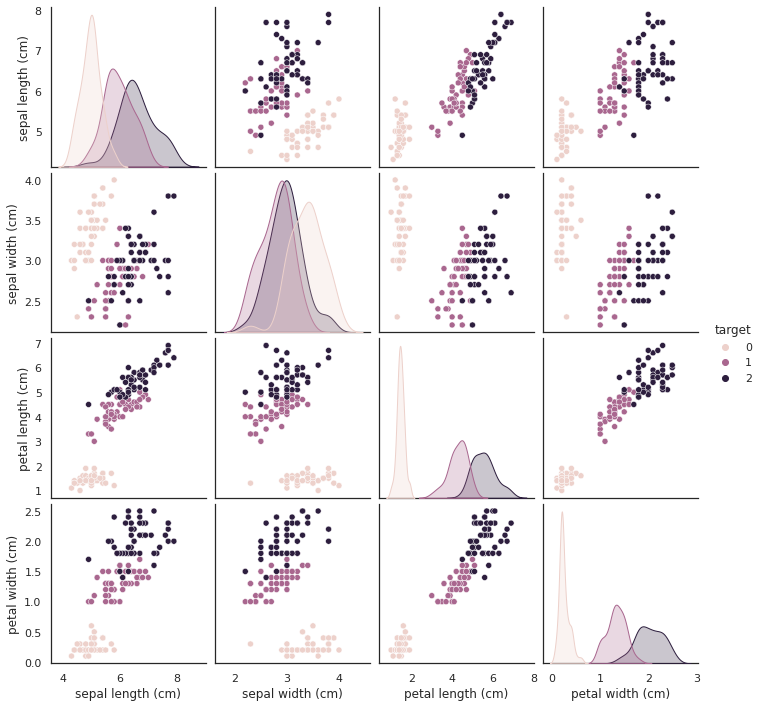

In [21]:
sns.pairplot(df, hue=y_label if CLASSIFICATION else None)

Target looks like classification
Linear Discriminant Analysis training set score: 0.980


[[<Figure size 864x864 with 20 Axes>,
  <Figure size 1152x288 with 4 Axes>,
  <Figure size 288x288 with 1 Axes>],
 None]

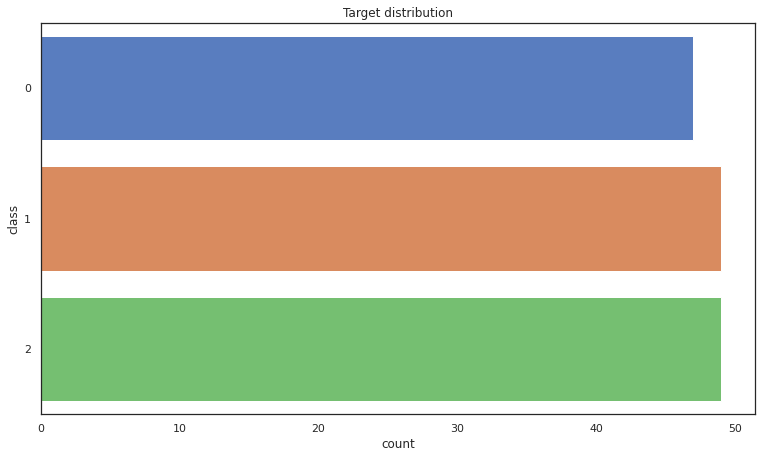

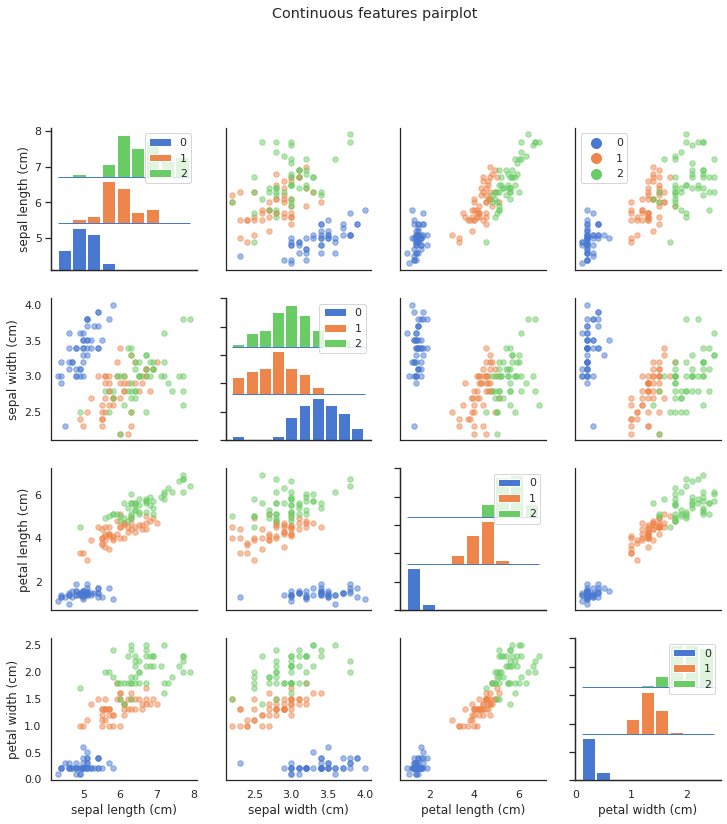

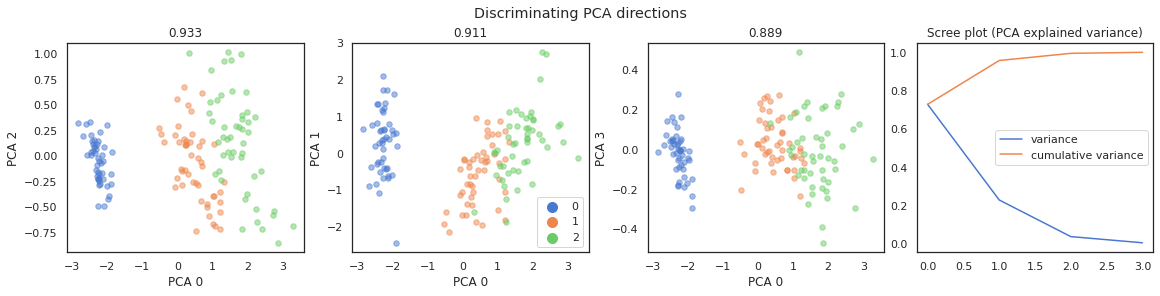

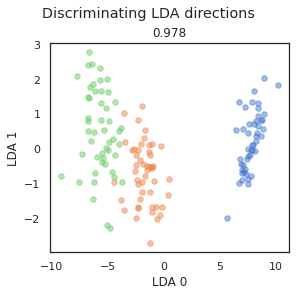

In [22]:
# import dtale
# dtale.show(df)
plot(X[col_num], y)

In [23]:
def build_ml_model():
    tests = [
        {
            "model": make_pipeline(
                (preprocessor),
                (SelectPercentile()),
                (RandomForestClassifier()) if CLASSIFICATION else (LinearRegression()),
            ),
            "params": {
                "columntransformer__pipeline-3__knnimputer__n_neighbors": [1, 3, 5, 7, 9],
                "selectpercentile__percentile": [i * 10 for i in range(1, 10)],
                "selectpercentile__score_func": [chi2, f_classif],
                "randomforestclassifier__n_estimators": [100, 150, 200, 500],
                "randomforestclassifier__criterion": ["gini", "entropy"],
                "randomforestclassifier__max_depth": [5, 10, 20, 50, 100, 200],
                "randomforestclassifier__min_samples_split": [2, 5, 10, 20, 50, 100, 200],
                "randomforestclassifier__min_samples_leaf": [5, 10, 20, 50, 100, 200],
                "randomforestclassifier__max_features": ["auto", "sqrt", "log2"],
            }
            if CLASSIFICATION
            else {
                "columntransformer__pipeline-3__knnimputer__n_neighbors": [1, 3, 5, 7, 9],
                "selectpercentile__percentile": [i * 10 for i in range(1, 10)],
                "selectpercentile__score_func": [chi2, f_classif],
            },
        },
    ]
    for test in tests:
        rscv = RandomizedSearchCV(
            estimator=test["model"],
            param_distributions=test["params"],
            n_jobs=-1,
            cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
            if CLASSIFICATION
            else 10,
            scoring="accuracy" if CLASSIFICATION else "r2",
            n_iter=10,
            return_train_score=True,
        )
        rscv.fit(X_train, y_train)
        print("===train============================")
        print(f"{rscv.best_score_ * 100:.2f}%\n{test['model'][-1]}\n{rscv.best_params_}")
        print("===params============================")
        display(pd.DataFrame(rscv.cv_results_).sort_values(by="rank_test_score"))
        print("===test============================")
        print(f"test score:{rscv.score(X_test, y_test) * 100:.2f}%")
        print("====end===========================\n")

    if CLASSIFICATION:
        SimpleClassifier(random_state=RANDOM_STATE).fit(df, target_col=y_label)
        print("-------------------------------------------------------")
        print(
            classification_report(
                y_test,
                rscv.predict(X_test),
            )
        )
        sns.heatmap(
            tf.math.confusion_matrix(
                y_test,
                rscv.predict(X_test),
            ),
            cmap="Blues",
            fmt="d",
            annot=True,
            linewidths=1,
        )
        plt.xlabel("Predicted")
        plt.ylabel("Truth")

    else:
        SimpleRegressor(random_state=RANDOM_STATE).fit(df, target_col=y_label)
        print("-------------------------------------------------------")
        print(
            f"r2: {r2_score(y_test, rscv.predict(X_test)):.3f} neg_mean_squared_error: -{mean_squared_error(y_test, rscv.predict(X_test)):_.3f}"
        )

        plt.subplot(1, 3, 1)
        sns.regplot(y_train, y_train, color="darkorange", label="Truth")
        sns.regplot(
            y_test,
            rscv.predict(X_test),
            color="darkcyan",
            label="Predicted",
        )
        plt.title(
            "Truth vs Predicted",
            fontsize=10,
        )
        plt.xlabel("Truth values")
        plt.ylabel("Predicted values")
        plt.legend()
        plt.grid()

        plt.subplot(1, 3, 2)
        plt.scatter(
            rscv.predict(X_train),
            rscv.predict(X_train) - y_train,
            c="darkorange",
            marker="o",
            s=35,
            alpha=0.5,
            label="Train data",
        )
        plt.scatter(
            rscv.predict(X_test),
            rscv.predict(X_test) - y_test,
            c="darkcyan",
            marker="o",
            s=35,
            alpha=0.7,
            label="Test data",
        )
        plt.title(
            "Predicted vs Residuals",
            fontsize=10,
        )
        plt.xlabel("Predicted values")
        plt.ylabel("Residuals")
        plt.legend(loc="upper right")
        plt.hlines(y=0, xmin=0, xmax=df[y_label].max(), lw=2, color="red")
        plt.grid()

        plt.subplot(1, 3, 3)
        sns.distplot((y_train - rscv.predict(X_train)))
        plt.title("Error Terms")
        plt.xlabel("Errors")
        plt.grid()

    plt.show()
    display(
        pd.DataFrame(
            {
                "Truth": y_test[:10].values,
                "Predicted": rscv.predict(X_test[:10]).round(1),
            }
        )
    )

def build_dl_model(hp):
    model = keras.models.Sequential()
    model.add(
        keras.layers.Dense(
            units=hp.Int("input_00", min_value=32, max_value=512, step=32),
            input_shape=X_train_processed.shape[1:],
        )
    )
    for i in range(1, hp.Int("num_layers", min_value=2, max_value=64)):
        model.add(
            keras.layers.Dense(
                units=hp.Int(f"hidden_{i:02}", min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
        model.add(keras.layers.Dropout(hp.Float("dropout", min_value=0, max_value=0.5, step=0.1)))
    model.add(
        keras.layers.Dense(
            units=[1, 1, df[y_label].nunique()][CLASSIFICATION],
            activation=["linear", "sigmoid", "softmax"][CLASSIFICATION],
        )
    )
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
        ),
        loss=["mean_squared_error", "binary_crossentropy", "sparse_categorical_crossentropy"][CLASSIFICATION],
        metrics=["mean_squared_error", "accuracy", "accuracy"][CLASSIFICATION],
    )
    return model

def get_result(epochs):
    model = tuner.hypermodel.build(best_hps)
    model.fit(
        X_train_processed,
        y_train_processed,
        batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
        epochs=epochs,
        validation_split=0.2,
        verbose=1,
    )
    if CLASSIFICATION:
        SimpleClassifier(random_state=RANDOM_STATE).fit(df, target_col=y_label)
        print("-------------------------------------------------------")
        print(
            classification_report(
                y_test_processed,
                [
                    model.predict(X_test_processed).round(),
                    np.argmax(model.predict(X_test_processed), axis=1),
                ][CLASSIFICATION - 1],
            )
        )
        sns.heatmap(
            tf.math.confusion_matrix(
                y_test_processed,
                [
                    model.predict(X_test_processed).round(),
                    np.argmax(model.predict(X_test_processed), axis=1),
                ][CLASSIFICATION - 1],
            ),
            cmap="Blues",
            fmt="d",
            annot=True,
            linewidths=1,
        )
        plt.xlabel("Predicted")
        plt.ylabel("Truth")

    else:
        SimpleRegressor(random_state=RANDOM_STATE).fit(df, target_col=y_label)
        print("-------------------------------------------------------")
        print(f"r2: {r2_score(y_test_processed, model.predict(X_test_processed).T[0]):.3f} neg_mean_squared_error: -{mean_squared_error(y_test_processed, model.predict(X_test_processed)):_.3f}")
    
        plt.subplot(1, 3, 1)
        sns.regplot(y_train_processed, y_train_processed, color="darkorange", label="Truth")
        sns.regplot(
            y_test_processed,
            model.predict(X_test_processed).T[0],
            color="darkcyan",
            label="Predicted",
        )
        plt.title(
            "Truth vs Predicted",
            fontsize=10,
        )
        plt.xlabel("Truth values")
        plt.ylabel("Predicted values")
        plt.legend()
        plt.grid()

        plt.subplot(1, 3, 2)
        plt.scatter(
            model.predict(X_train_processed).T[0],
            model.predict(X_train_processed).T[0] - y_train_processed,
            c="darkorange",
            marker="o",
            s=35,
            alpha=0.5,
            label="Train data",
        )
        plt.scatter(
            model.predict(X_test_processed).T[0],
            model.predict(X_test_processed).T[0] - y_test_processed,
            c="darkcyan",
            marker="o",
            s=35,
            alpha=0.7,
            label="Test data",
        )
        plt.title(
            "Predicted vs Residuals",
            fontsize=10,
        )
        plt.xlabel("Predicted values")
        plt.ylabel("Residuals")
        plt.legend(loc="upper right")
        plt.hlines(y=0, xmin=0, xmax=df[y_label].max(), lw=2, color="red")
        plt.grid()

        plt.subplot(1, 3, 3)
        sns.distplot((y_train_processed - model.predict(X_train_processed).T[0]))
        plt.title("Error Terms")
        plt.xlabel("Errors")
        plt.grid()

    plt.show()

    display(
        pd.DataFrame(
            {
                "Truth": y_test_processed[:10].values,
                "Predicted": [
                    model.predict(X_test_processed[:10]).T[0],
                    model.predict(X_test_processed[:10]).T[0].round(),
                    np.argmax(model.predict(X_test_processed[:10]), axis=1),
                ][CLASSIFICATION],
            }
        )
    )
    return model

if SEARCH == "hyperband":
    tuner = Hyperband(
        build_dl_model,
        objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION],
        max_epochs=MAX_TRIALS,
        factor=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
elif SEARCH == "random":
    tuner = RandomSearch(
        build_dl_model,
        objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION],
        max_trials=MAX_TRIALS,
        executions_per_trial=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
else:
    tuner = BayesianOptimization(
        build_dl_model,
        objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION],
        max_trials=MAX_TRIALS,
        executions_per_trial=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=int(MAX_TRIALS/4))
tuner.search_space_summary()

Search space summary
Default search space size: 5
input_00 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 64, 'step': 1, 'sampling': None}
hidden_01 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


2022-04-09 23:33:30.077992: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [34]:
%%time
tuner.search(
    X_train_processed,
    y_train_processed,
    batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
    callbacks=[early_stop],
    epochs=MAX_TRIALS,
    validation_split=0.2,
    verbose=1,
)
tuner.results_summary()

Trial 42 Complete [00h 00m 08s]
val_accuracy: 0.3333333432674408

Best val_accuracy So Far: 0.9583333134651184
Total elapsed time: 00h 05m 40s
Results summary
Results in ./keras_tuner
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
input_00: 128
num_layers: 19
hidden_01: 96
dropout: 0.30000000000000004
learning_rate: 0.001
hidden_02: 416
hidden_03: 384
hidden_04: 512
hidden_05: 352
hidden_06: 224
hidden_07: 160
hidden_08: 448
hidden_09: 384
hidden_10: 64
hidden_11: 416
hidden_12: 352
hidden_13: 160
hidden_14: 480
hidden_15: 384
hidden_16: 352
hidden_17: 160
hidden_18: 288
hidden_19: 416
hidden_20: 384
hidden_21: 320
hidden_22: 160
hidden_23: 288
hidden_24: 288
hidden_25: 512
hidden_26: 448
hidden_27: 320
hidden_28: 480
hidden_29: 448
hidden_30: 480
hidden_31: 32
hidden_32: 192
hidden_33: 448
hidden_34: 96
hidden_35: 352
hidden_36: 320
hidden_37: 64
hidden_38: 480
hidden_39: 256
hidden_40: 96
hidden_41: 96
hidden_42: 64
hidden_43: 64

Epoch 1/500
2/2 [==============================] - 2s 347ms/step - loss: 1.0985 - accuracy: 0.3370 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 2/500
2/2 [==============================] - 0s 54ms/step - loss: 1.0993 - accuracy: 0.3261 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 3/500
2/2 [==============================] - 0s 52ms/step - loss: 1.0987 - accuracy: 0.3587 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 4/500
2/2 [==============================] - 0s 55ms/step - loss: 1.0923 - accuracy: 0.3370 - val_loss: 1.0963 - val_accuracy: 0.3333
Epoch 5/500
2/2 [==============================] - 0s 54ms/step - loss: 1.0830 - accuracy: 0.3370 - val_loss: 1.0767 - val_accuracy: 0.3333
Epoch 6/500
2/2 [==============================] - 0s 53ms/step - loss: 1.0471 - accuracy: 0.3370 - val_loss: 1.0187 - val_accuracy: 0.3333
Epoch 7/500
2/2 [==============================] - 0s 53ms/step - loss: 1.0633 - accuracy: 0.3370 - val_loss: 0.9931 - val_accuracy: 0.3333
Epoch 8/500
2/2 [==

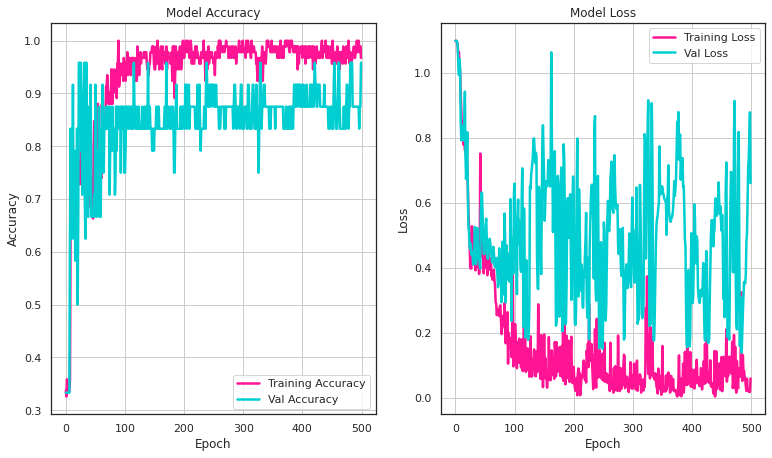

CPU times: user 1min 4s, sys: 7.43 s, total: 1min 11s
Wall time: 43.5 s


In [35]:
%%time
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    X_train_processed,
    y_train_processed,
    batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=1,
)
val_per_epoch = history.history[
    ["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION]
]
best_epoch = val_per_epoch.index([min(val_per_epoch), max(val_per_epoch), max(val_per_epoch)][CLASSIFICATION]) + 1

plt.subplot(1, 2, 1)
plt.plot(history.history[["mean_squared_error", "accuracy", "accuracy"][CLASSIFICATION]], color='deeppink', linewidth=2.5)
plt.plot(history.history[["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION]], color='darkturquoise', linewidth=2.5)
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training Accuracy", "Val Accuracy"], loc="lower right")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], color='deeppink', linewidth=2.5)
plt.plot(history.history["val_loss"], color='darkturquoise', linewidth=2.5)
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training Loss", "Val Loss"], loc="upper right")
plt.grid()
plt.show()

Best epoch: 23
Epoch 1/23
2/2 [==============================] - 2s 345ms/step - loss: 1.0983 - accuracy: 0.3261 - val_loss: 1.0982 - val_accuracy: 0.3333
Epoch 2/23
2/2 [==============================] - 0s 52ms/step - loss: 1.0934 - accuracy: 0.3152 - val_loss: 1.0924 - val_accuracy: 0.3333
Epoch 3/23
2/2 [==============================] - 0s 51ms/step - loss: 1.0729 - accuracy: 0.3370 - val_loss: 1.0415 - val_accuracy: 0.3333
Epoch 4/23
2/2 [==============================] - 0s 53ms/step - loss: 1.0224 - accuracy: 0.3370 - val_loss: 0.9720 - val_accuracy: 0.3333
Epoch 5/23
2/2 [==============================] - 0s 53ms/step - loss: 0.9788 - accuracy: 0.3478 - val_loss: 0.9954 - val_accuracy: 0.6250
Epoch 6/23
2/2 [==============================] - 0s 52ms/step - loss: 0.8862 - accuracy: 0.4348 - val_loss: 0.9073 - val_accuracy: 0.6250
Epoch 7/23
2/2 [==============================] - 0s 51ms/step - loss: 0.8604 - accuracy: 0.6848 - val_loss: 0.8229 - val_accuracy: 0.6250
Epoch 8/23


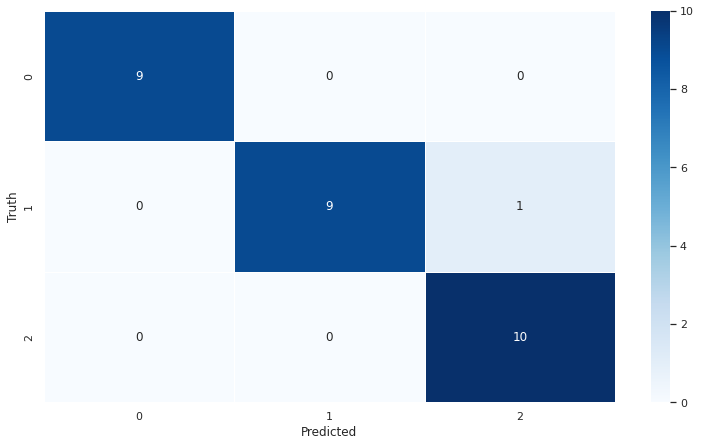

,Truth,Predicted
0,1,1
1,2,2
2,0,0
3,0,0
4,2,2
5,1,1
6,0,0
7,2,2
8,1,1
9,2,2


CPU times: user 6.32 s, sys: 568 ms, total: 6.88 s
Wall time: 5.26 s


In [36]:
%%time
print(f"Best epoch: {best_epoch}")
model = get_result(best_epoch)

===train============================
95.76%
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
{'selectpercentile__score_func': <function f_classif at 0x7f07be951cb0>, 'selectpercentile__percentile': 40, 'randomforestclassifier__n_estimators': 500, 'randomforestclassifier__min_samples_split': 50, 'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 200, 'randomforestclassifier__criterion': 'gini', 'columntransformer__pipeline-3__knnimputer__n_neighbors': 5}
===params=

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_selectpercentile__score_func,param_selectpercentile__percentile,param_randomforestclassifier__n_estimators,param_randomforestclassifier__min_samples_split,param_randomforestclassifier__min_samples_leaf,param_randomforestclassifier__max_features,param_randomforestclassifier__max_depth,param_randomforestclassifier__criterion,param_columntransformer__pipeline-3__knnimputer__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
4,1.247880,0.032641,0.093404,0.003498,<function f_classif at 0x7f07be951cb0>,40,500,50,10,log2,200,gini,5,{'selectpercentile__score_func': <function f_c...,1.000000,0.916667,0.916667,0.916667,1.000000,0.916667,1.000000,1.000000,0.909091,1.000000,0.957576,0.042478,1,0.961538,0.971154,0.951923,0.980769,0.961538,0.971154,0.952381,0.961905,0.971429,0.961905,0.964570,0.008586
2,0.500357,0.005126,0.040716,0.001928,<function chi2 at 0x7f07be956200>,90,200,10,10,auto,200,entropy,3,{'selectpercentile__score_func': <function chi...,1.000000,1.000000,1.000000,0.833333,1.000000,0.916667,0.909091,0.909091,0.909091,1.000000,0.947727,0.056737,2,0.961538,0.971154,0.942308,0.971154,0.951923,0.961538,0.961905,0.961905,0.971429,0.961905,0.961676,0.008633
5,1.320592,0.118824,0.108107,0.030438,<function f_classif at 0x7f07be951cb0>,20,500,5,20,log2,10,entropy,3,{'selectpercentile__score_func': <function f_c...,1.000000,0.833333,0.916667,0.916667,1.000000,0.916667,1.000000,0.909091,0.818182,1.000000,0.931061,0.065121,3,0.942308,0.961538,0.951923,0.951923,0.942308,0.951923,0.942857,0.952381,0.961905,0.942857,0.950192,0.007153
7,0.257264,0.004566,0.024370,0.003588,<function f_classif at 0x7f07be951cb0>,20,100,10,10,sqrt,10,entropy,5,{'selectpercentile__score_func': <function f_c...,1.000000,0.833333,0.916667,0.916667,1.000000,0.916667,1.000000,0.909091,0.818182,1.000000,0.931061,0.065121,3,0.942308,0.961538,0.951923,0.951923,0.942308,0.951923,0.942857,0.952381,0.961905,0.942857,0.950192,0.007153
1,0.372071,0.004812,0.030685,0.001295,<function f_classif at 0x7f07be951cb0>,80,150,2,100,log2,10,entropy,7,{'selectpercentile__score_func': <function f_c...,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.272727,0.363636,0.272727,0.363636,0.327273,0.029691,5,0.336538,0.336538,0.336538,0.336538,0.336538,0.336538,0.342857,0.333333,0.333333,0.333333,0.336209,0.002639
6,1.249614,0.036119,0.089352,0.001629,<function chi2 at 0x7f07be956200>,20,500,200,5,sqrt,5,entropy,1,{'selectpercentile__score_func': <function chi...,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.272727,0.272727,0.363636,0.363636,0.327273,0.029691,5,0.336538,0.336538,0.336538,0.336538,0.336538,0.336538,0.342857,0.342857,0.333333,0.333333,0.337161,0.003107
9,0.485823,0.023456,0.036582,0.007413,<function chi2 at 0x7f07be956200>,80,200,100,200,auto,200,entropy,3,{'selectpercentile__score_func': <function chi...,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.272727,0.272727,0.363636,0.363636,0.327273,0.029691,5,0.336538,0.336538,0.336538,0.336538,0.336538,0.336538,0.342857,0.342857,0.333333,0.333333,0.337161,0.003107
3,0.494597,0.007793,0.039887,0.001720,<function chi2 at 0x7f07be956200>,70,200,5,50,log2,10,entropy,5,{'selectpercentile__score_func': <function chi...,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.272727,0.272727,0.363636,0.272727,0.318182,0.031051,8,0.336538,0.336538,0.336538,0.336538,0.336538,0.336538,0.342857,0.342857,0.333333,0.333333,0.337161,0.003107
0,0.500430,0.016509,0.040358,0.001647,<function f_classif at 0x7f07be951cb0>,20,200,200,5,sqrt,5,entropy,

===test============================
test score:100.00%
====end===========================

Running DummyClassifier()
accuracy: 0.331 recall_macro: 0.333 precision_macro: 0.110 f1_macro: 0.166
=== new best DummyClassifier() (using recall_macro):
accuracy: 0.331 recall_macro: 0.333 precision_macro: 0.110 f1_macro: 0.166

Running GaussianNB()
accuracy: 0.952 recall_macro: 0.953 precision_macro: 0.955 f1_macro: 0.952
=== new best GaussianNB() (using recall_macro):
accuracy: 0.952 recall_macro: 0.953 precision_macro: 0.955 f1_macro: 0.952

Running MultinomialNB()
accuracy: 0.745 recall_macro: 0.753 precision_macro: 0.759 f1_macro: 0.716
Running DecisionTreeClassifier(class_weight='balanced', max_depth=1)
accuracy: 0.655 recall_macro: 0.667 precision_macro: 0.496 f1_macro: 0.552
Running DecisionTreeClassifier(class_weight='balanced', max_depth=5)
accuracy: 0.952 recall_macro: 0.952 precision_macro: 0.953 f1_macro: 0.952
Running DecisionTreeClassifier(class_weight='balanced', min_impurity_dec

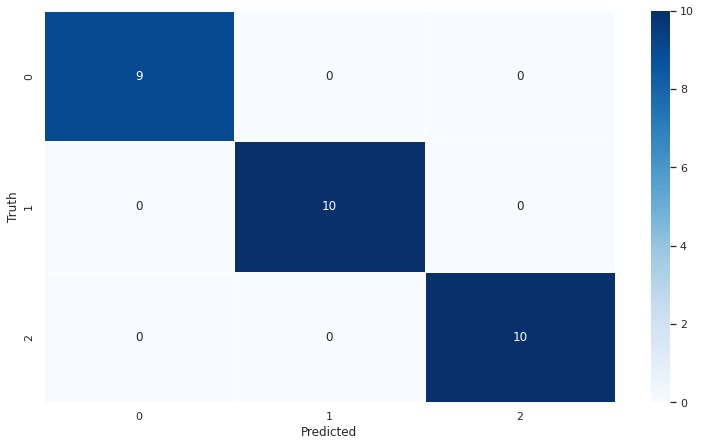

,Truth,Predicted
0,1,1
1,2,2
2,0,0
3,0,0
4,2,2
5,1,1
6,0,0
7,2,2
8,1,1
9,2,2


In [38]:
build_ml_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 128)               640       
_________________________________________________________________
dense_74 (Dense)             (None, 96)                12384     
_________________________________________________________________
dropout_69 (Dropout)         (None, 96)                0         
_________________________________________________________________
dense_75 (Dense)             (None, 416)               40352     
_________________________________________________________________
dropout_70 (Dropout)         (None, 416)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 384)               160128    
_________________________________________________________________
dropout_71 (Dropout)         (None, 384)              

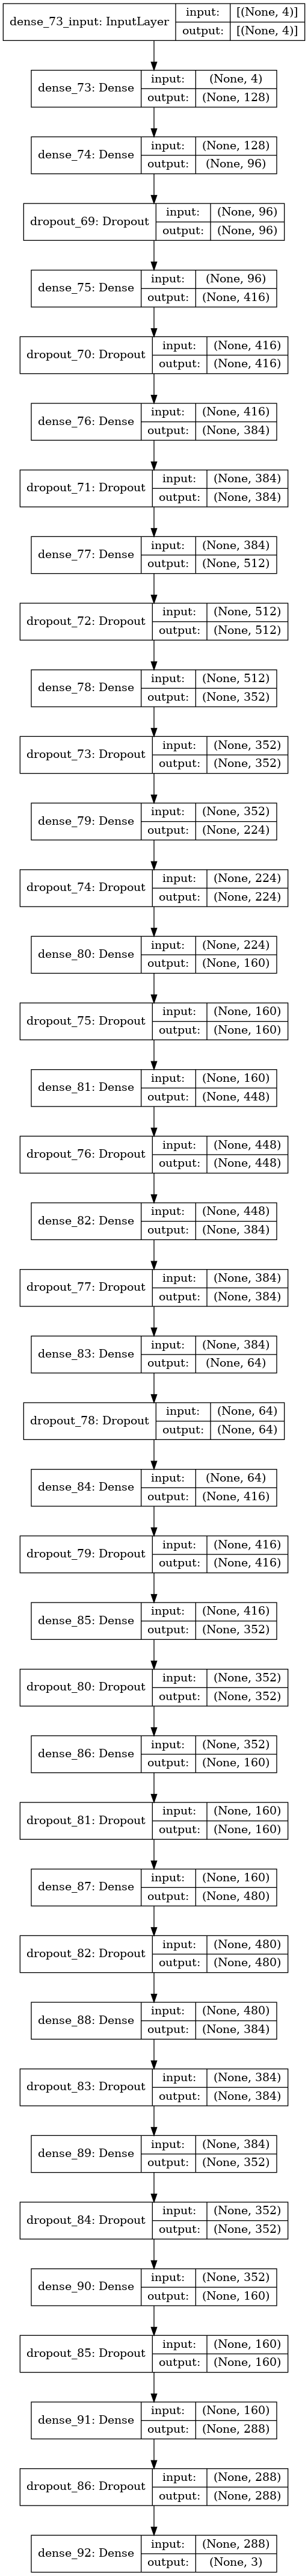

In [39]:
model.summary()
plot_model(model, show_shapes=True)

In [42]:
model.save(f"dl_model_{time_stamp}")
shutil.make_archive(f"dl_model_{time_stamp}", "zip", f"./dl_model_{time_stamp}")
dump(preprocessor, open(f"dl_preprocessor.pkl", "wb"))